#DK - Bootstrapping - from 0610 lecture (6.WhitesRealityCheck.pptx) - very important 

Googling:
https://statisticsbyjim.com/hypothesis-testing/bootstrapping/

Bootstrapping is a statistical procedure that resamples a single dataset to create many simulated samples. 
This process allows you to calculate standard errors, construct confidence intervals, and perform hypothesis testing 
for numerous types of sample statistics. Bootstrap methods are alternative approaches to traditional hypothesis testing 
and are notable for being easier to understand and valid for more conditions.

From 'WhiteRealityCheckFor1.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
#seaborn.mpl.rcParams['savefig.dpi'] = 90
'''
https://people.duke.edu/~ccc14/sta-663/ResamplingAndMonteCarloSimulations.html
This subroutine will calculate White's Reality Check for a single trading rule
in accordance with Aronson's Evidence Based Technical Analysis p.237ff

'''


#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)


    
    #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
   # plt.show()
    

    #about the histogram
    #https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
    #R(n^(1/3))/(3.49σ)
    #R is the range of data (in your case R = 3-(-3)= 6),
    #n is the number of samples,
    #σ is your standard deviation.


In [ ]:
import statsmodels.api as sm

def detrendPrice(series):
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x)
    model = sm.OLS(y,x_const)
    result = model.fit()
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid 

# Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
AAPL_csv = pd.read_csv(r"/content/drive/MyDrive/AAPL.csv")
AAPL_csv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-29,36.177502,36.282501,35.570000,35.919998,34.004253,125997600
1,2017-06-30,36.112499,36.240002,35.945000,36.005001,34.084721,92096400
2,2017-07-03,36.220001,36.325001,35.775002,35.875000,33.961651,57111200
3,2017-07-05,35.922501,36.197498,35.680000,36.022499,34.101276,86278400
4,2017-07-06,35.755001,35.875000,35.602501,35.682499,33.779408,96515200


In [8]:
df = pd.DataFrame()

Feature 1: Relative Strength Index (RSI)

This is a technical analysis tools used to determine the strength or weakness of a stock's price.

In [9]:
high = AAPL_csv["High"]
low = AAPL_csv["Low"]
rsi = np.array(100-(100/(1+high/low)))
df["rsi"] = rsi

Feature 2: Moving Average Convergence-DIvergence (MACD)

This is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The most popular length of the fast and slow is 12, 26 respectively.

[source: https://medium.com/codex/algorithmic-trading-with-macd-in-python-1c2769a6ad1b]

In [10]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    return macd

macd = get_macd(AAPL_csv['Close'], 26, 12, 9)
macd.head()

df['macd'] = macd

Features 3 and 4: Stochastic Oscillator

This measures the relationship between an issue's closing price and its price range over a predetermined period of time.

[source: https://www.alpharithms.com/stochastic-oscillator-in-python-483214/]

In [11]:
fast_period = 14
slow_period = 3

# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = AAPL_csv['High'].rolling(fast_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = AAPL_csv['Low'].rolling(fast_period).min()
# Uses the min/max values to calculate the fast line (as a percentage)
df['SO_fast'] = (AAPL_csv['Close'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the fast line to calculates a SMA over the past 3 values
df['SO_slow'] = df['SO_fast'].rolling(slow_period).mean()

df.drop(['n_high','n_low'],axis=1,inplace=True)

Features 5, 6 and 7: Percentage difference between the closing price and the 5, 8, and 13 day Exponential Moving Average (EMA) 

EMA is similar to Simple Moving Average but it applies more weight to data

In [12]:
df["ema_5"] = np.array(pd.Series(np.array(AAPL_csv['Adj Close'])).ewm(span=5, adjust=False).mean().fillna(1).tolist())
df["ema_8"] = np.array(pd.Series(np.array(AAPL_csv['Adj Close'])).ewm(span=8, adjust=False).mean().fillna(1).tolist())
df["ema_13"] = np.array(pd.Series(np.array(AAPL_csv['Adj Close'])).ewm(span=13, adjust=False).mean().fillna(1).tolist())

df["DiffClose5_EMA"] = (AAPL_csv['Adj Close']-df["ema_5"])/df["ema_5"]
df["DiffClose8_EMA"] = (AAPL_csv['Adj Close']-df["ema_8"])/df["ema_8"]
df["DiffClose13_EMA"] = (AAPL_csv['Adj Close']-df["ema_13"])/df["ema_13"]

df.drop(['ema_5','ema_8','ema_13'],axis=1,inplace=True)

Features 8 and 9: Difference between Closing Price & Bollinger Bands

This is a technical analysis tool defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price, but which can be adjusted to user preferences.

In [13]:
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

df['sma_20'] = sma(AAPL_csv['Close'], 20)
df.tail()


def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(AAPL_csv['Close'], df['sma_20'], 20)

df["DiffCloseUpper"] =  df['upper_bb'] - AAPL_csv['Adj Close']
df["DiffCloseLower"] =  AAPL_csv['Adj Close'] - df['lower_bb'] 

df.drop(['sma_20','upper_bb','lower_bb'], axis=1, inplace=True)

In [14]:
df.fillna(0,inplace=True)
df.tail()

,rsi,macd,SO_fast,SO_slow,DiffClose5_EMA,DiffClose8_EMA,DiffClose13_EMA,DiffCloseUpper,DiffCloseLower
1253,50.708579,-4.753417,28.385110,23.191515,0.005410,-0.001676,-0.015706,19.821584,8.128593
1254,50.539711,-4.310890,44.311138,34.261449,0.017905,0.015380,0.004736,16.854561,11.210566
1255,50.379864,-3.644627,60.585741,44.427330,0.028172,0.031047,0.025068,13.521039,14.543045
1256,50.442945,-3.081091,60.585741,55.160873,0.018606,0.023982,0.021410,13.363290,14.597295
1257,51.086413,-2.941101,40.326492,53.832658,-0.007856,-0.005080,-0.007739,16.448673,10.462674


Encoding target variable:

We are trying to predict the closing price of the following trading day into one of the following 4 bands:

* adjClosePChange <-1%
* -1% <= adjClosePChange < 0%
* 0% <= adjClosePChange < 1%
* 1% <= adjClosePChange


In [15]:
AAPL_csv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-29,36.177502,36.282501,35.570000,35.919998,34.004253,125997600
1,2017-06-30,36.112499,36.240002,35.945000,36.005001,34.084721,92096400
2,2017-07-03,36.220001,36.325001,35.775002,35.875000,33.961651,57111200
3,2017-07-05,35.922501,36.197498,35.680000,36.022499,34.101276,86278400
4,2017-07-06,35.755001,35.875000,35.602501,35.682499,33.779408,96515200


In [16]:
AAPL_csv['Adj Close'].pct_change(1).shift(0).fillna(0)

0       0.000000
1       0.002366
2      -0.003611
3       0.004111
4      -0.009439
          ...   
1253   -0.003827
1254    0.021574
1255    0.024517
1256    0.000000
1257   -0.029790
Name: Adj Close, Length: 1258, dtype: float64

In [17]:
change = []
adj_close_change = AAPL_csv['Adj Close'].pct_change(1).shift(0).fillna(0)

for i in adj_close_change:
  if i < -0.01:
    change.append(0)
  elif -0.01 <= i <=0:
    change.append(1)
  elif 0 < i <= 0.01:
    change.append(2)
  else:
    change.append(3)

df["Change"] = np.array(change)

In [18]:
df.head()

,rsi,macd,SO_fast,SO_slow,DiffClose5_EMA,DiffClose8_EMA,DiffClose13_EMA,DiffCloseUpper,DiffCloseLower,Change
0,50.495808,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1
1,50.204337,0.006781,0.0,0.0,0.001576,0.001840,0.002028,0.0,0.0,2
2,50.381414,0.001646,0.0,0.0,-0.001361,-0.001383,-0.001363,0.0,0.0,1
3,50.359986,0.009370,0.0,0.0,0.001828,0.002116,0.002350,0.0,0.0,2
4,50.190619,-0.011807,0.0,0.0,-0.005098,-0.005720,-0.006102,0.0,0.0,1


In [19]:
df['Change'].unique()

array([1, 2, 3, 0])

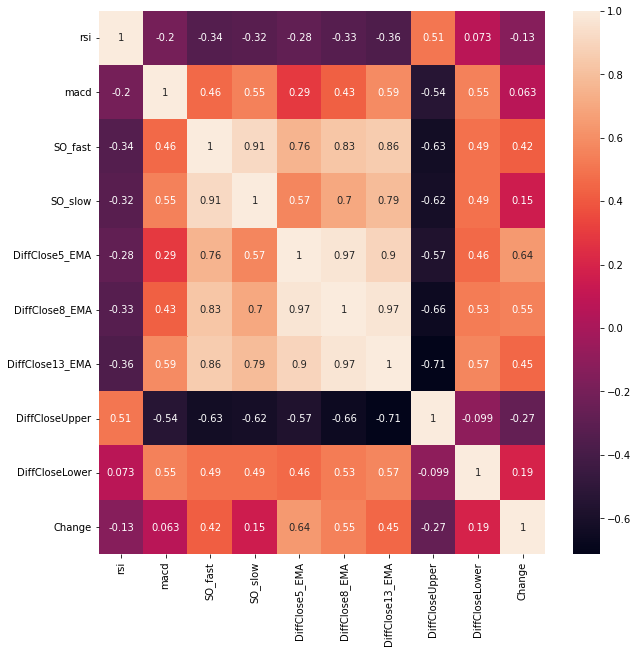

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [21]:
# DK 20220810
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df['Change']
# 70% training data, 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 


# Model Selection

KNN

Try adjusting the following hyperparammeter:

- n_neighbors
- leaf_size
- p value

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


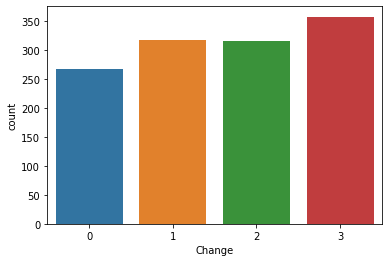

In [ ]:
#Understanding data distribution
sns.countplot(df['Change'])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors

#Tuning hyperparameters
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
best_model = clf.fit(X_train,y_train)

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


# Training classifiers
#knn = neighbors.KNeighborsClassifier(n_neighbors=5)
#knn.fit(X_train, y_train)


Best leaf_size: 1
Best p: 2
Best n_neighbors: 8


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        76
           1       0.46      0.49      0.48        87
           2       0.41      0.40      0.41        98
           3       0.71      0.68      0.69       117

    accuracy                           0.58       378
   macro avg       0.58      0.59      0.58       378
weighted avg       0.58      0.58      0.58       378



0.8070144861893384

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


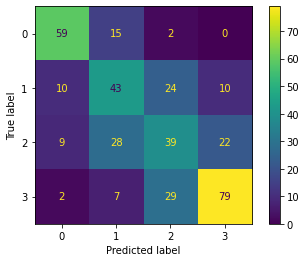

In [ ]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, X_test, y_test)

In [ ]:
# error of train and testing data
error_test = 1-best_model.score(X_test,y_test)
error_train = 1-best_model.score(X_train,y_train)
print("The error of training dataset is", error_train)
print("The error of testing dataset is", error_test)

The error of training dataset is 0.3352272727272727
The error of testing dataset is 0.417989417989418


average return -0.004016
[-0.01525657  0.01631048]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.6996


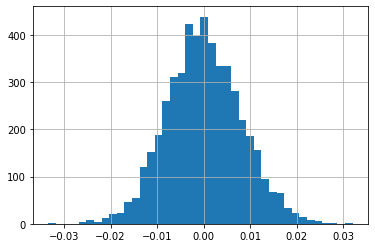

In [ ]:
# calculate the p-value
positions2 = np.where(clf.predict(X_test)> 0,1,-1 ) 
detrended_open = detrendPrice(AAPL_csv['Open'][1000:])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)

Random Forest

Try adjusting the following hyperparammeters:
- n_estimators
- max_features
- min_samples_leaf

https://medium.com/towards-data-science/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [22]:
# DK
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Params
# estimator, param_distributions, n_iter, scoring, n_jobs, refit, cv, verbose, pre_dispatch, random_state, error_score, return_train_score

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 10, 15]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf}

# First create the base model to tune
RF = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 60 different combinations, and use all available cores
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 60, cv = 5, random_state = 42)

# Fit the random search model
RF_random.fit(X_train, y_train)

print ('Random grid: ', random_grid)

# Best Parameters
print ('Best Parameters: ', RF_random.best_params_)

Random grid:  {'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [4, 10, 15]}
Best Parameters:  {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


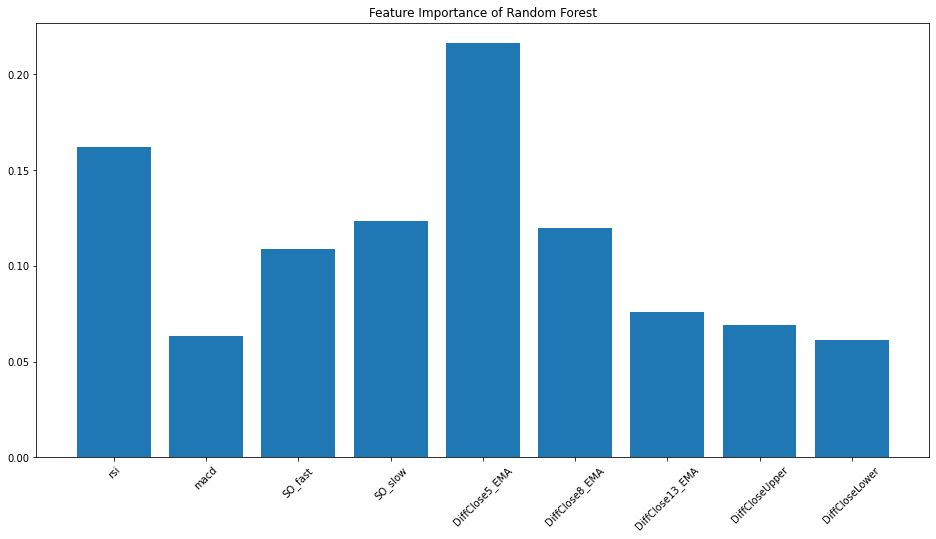

In [33]:
# DK
RF_best = RandomForestClassifier(n_estimators = 115, min_samples_split = 4, max_features = 'auto') 
RF_best.fit(X_train, y_train) 
y_pred_train_RF = RF_best.predict(X_train)
y_pred_test_RF = RF_best.predict(X_test)

feature_importance_RF = RF_best.feature_importances_
plt.figure(figsize = (16,8))

# Create plot title
plt.title("Feature Importance of Random Forest")

# Add bars
plt.bar(range(X_train.shape[1]),  feature_importance_RF)

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation = 45)

# Show plot
plt.show()

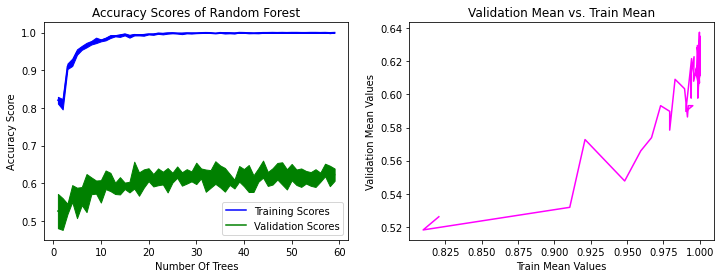

In [34]:
# DK
from sklearn.model_selection import validation_curve

# Create range of values for parameter
param_range = np.arange(1, 60, 1)

# Plot the graph of validation vs training scores
train_scores, val_scores = validation_curve(
    RandomForestClassifier(),
    X_train, y_train,
    param_name = "n_estimators",
    param_range = param_range,
    cv = 5,
    scoring = "accuracy",
    n_jobs = -1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

# Calculate mean and standard deviation for validation set scores
val_mean = np.mean(val_scores, axis = 1)
val_std = np.std(val_scores, axis = 1)

# Plot mean accuracy scores for training and validation sets in the aspect of n_estimators
fig=plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
plt.plot(param_range, train_mean, label="Training Scores", color = "blue")
plt.plot(param_range, val_mean, label="Validation Scores", color = "green")

# Plot accurancy bands for training and validation sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color = "blue")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, color = "green")

# Create plot
plt.title("Accuracy Scores of Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.legend(loc = "best")

#Plot the graph of val_mean vs train_mean
fig.add_subplot(1,2,2)
plt.plot(train_mean, val_mean, color = 'magenta')
plt.title("Validation Mean vs. Train Mean")
plt.xlabel("Train Mean Values")
plt.ylabel("Validation Mean Values")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


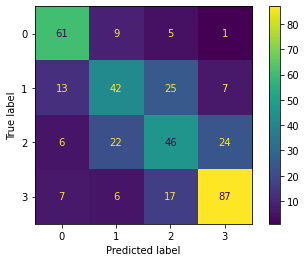

In [35]:
# DK
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RF_best, X_test, y_test)  

In [37]:
# DK
# Calculate precision/recall/accuarcy
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision_RF = precision_score(y_test, y_pred_test_RF, average="macro")
recall_RF = recall_score(y_test, y_pred_test_RF, average="macro")
accuarcy_RF = accuracy_score(y_test, y_pred_test_RF)
print("The precision of RF is", precision_RF)
print("The recall of RF is", recall_RF)
print("The accuarcy of RF is", accuarcy_RF)

The precision of RF is 0.6146277719490945
The recall of RF is 0.624591924582202
The accuarcy of RF is 0.6243386243386243


average return 0.001545
[-0.01540025  0.01603433]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.4226


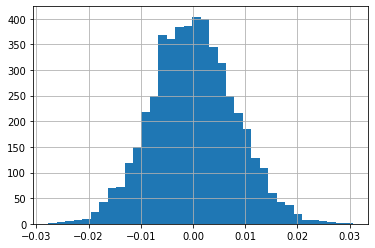

In [38]:
# DK
# p value
positions2 = np.where(RF_random.predict(X_test)> 0, 1, -1 ) 
detrended_open = detrendPrice(AAPL_csv['Open'][1000:])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)

Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000)
solvers = ['lbfgs', 'sag', 'saga','newton-cg'] 
class_weights = ['balanced', None]
c_values = [10, 1.0, 0.5, 0.1, 0.01]

# define grid search
grid_search = GridSearchCV(estimator=lr, param_grid=dict(solver=solvers,class_weight=class_weights,C=c_values),
                           n_jobs=-1, cv=3, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print ('Best Parameters: ', grid_result.best_params_, ' \n')

Best Parameters:  {'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}  



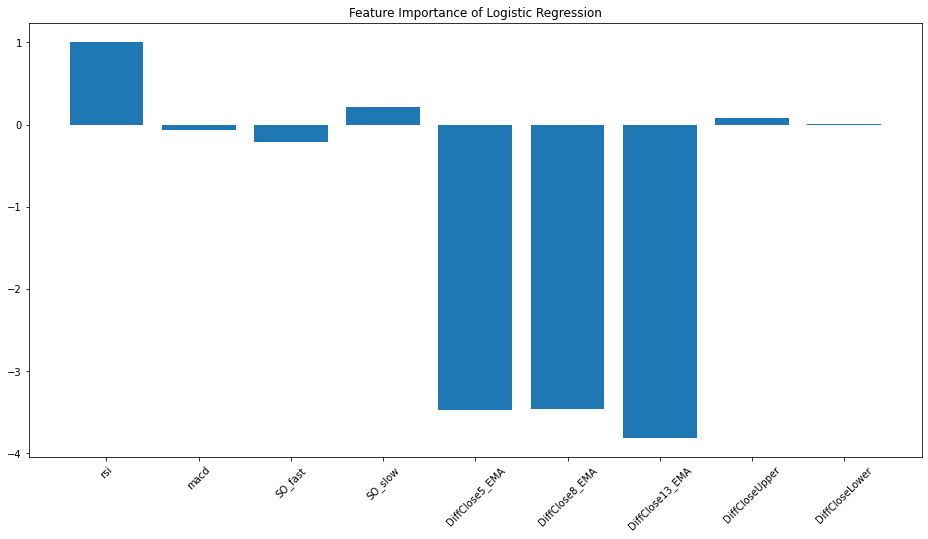

In [ ]:
LR_best = LogisticRegression(C = 10, class_weight = 'balanced', solver = 'lbfgs', max_iter = 10000) 
LR_best.fit(X_train, y_train) 
y_pred_train_LR = LR_best.predict(X_train)
y_pred_test_LR = LR_best.predict(X_test)

feature_importance_LR = LR_best.coef_[0]
plt.figure(figsize = (16,8))

# Create plot title
plt.title("Feature Importance of Logistic Regression")

# Add bars
plt.bar(range(X_train.shape[1]),  feature_importance_LR)

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation = 45)

# Show plot
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision_LR = precision_score(y_test, y_pred_test_LR, average="macro")
recall_LR = recall_score(y_test, y_pred_test_LR, average="macro")
accuarcy_LR = accuracy_score(y_test, y_pred_test_LR)
print("The precision of LR is", precision_LR)
print("The recall of LR is", recall_LR)
print("The accuarcy of LR is", accuarcy_LR)

The precision of LR is 0.631628822596777
The recall of LR is 0.6184746712682933
The accuarcy of LR is 0.6137566137566137


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


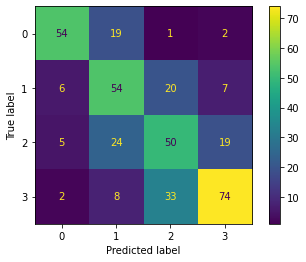

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR_best, X_test, y_test) 

average return 0.003176
[-0.01548258  0.01595775]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.3388


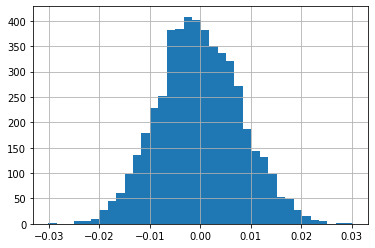

In [ ]:
# calculate the p-value

positions2 = np.where(grid_search.predict(X_test)> 0,1,-1 ) 
detrended_open = detrendPrice(AAPL_csv['Open'][1000:])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
bootstrap(detrended_syst_rets)